A notebook to format and upload the dhbv simulation into an icechunk store for versioning and cloud-optimized reads

#### Writing the icechunk store

In [6]:
from pathlib import Path

import icechunk
import numpy as np
import xarray as xr
import zarr
from icechunk.xarray import to_icechunk

To make sure we can push to the repo, we will need to add AWS credentials to our `~/.aws/credentials` under the profile name "CIROH_USER"

In [5]:
import boto3
import os

profile_name = "CIROH_USER"  # Replace with your AWS credentials file profile name
os.environ['AWS_PROFILE'] = profile_name

Next, we're going to point to the simulation that we want to convert to icechunk and read it into memory

In [ ]:
file_path = Path("~/data/dHBV_streamflow_simulation_gages")
bucket="mhpi-spatial"
prefix="dhbv_retrospective"
commit="initial streamflow commit"

In [ ]:
if file_path.exists() is False:
    raise FileNotFoundError(f"Cannot find: {file_path}")
root = zarr.open_group(file_path)
root.tree()

/
├── GAGEID (7368,) <U20
├── dHBV2.0UH_simulation (7368, 14976) float32
├── dHBV2.0dMC_simulation (7368, 14976) float32
├── observation (7368, 14976) float32
└── time (14976,) datetime64

In [13]:
for key, value in root.attrs.items():
    print(key)

Drainage area (km^2)
lat
lon


We'll need to convert this zarr v2 group into an xarray dataset

In [14]:
gageid_array = np.array(root['GAGEID'])
time_array = np.array(root['time'])
uh_sim_array = np.array(root['dHBV2.0UH_simulation'])
dmc_sim_array = np.array(root['dHBV2.0dMC_simulation'])
obs_array = np.array(root['observation'])

# Create the dataset with proper dimensions
ds = xr.Dataset(
    data_vars={
        'dHBV2.0UH_simulation': (('station', 'time'), uh_sim_array),
        'dHBV2.0dMC_simulation': (('station', 'time'), dmc_sim_array),
        'observation': (('station', 'time'), obs_array),
        'drainage_area': (('station'), root.attrs["Drainage area (km^2)"]),
        'lat': (('station'), root.attrs["lat"]),
        'lon': (('station'), root.attrs["lon"]),
    },
    coords={
        'station': (('station'), gageid_array),
        'time': (('time'), time_array),
    }
)

In [15]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:                (station: 7368, time: 14976)
Coordinates:
  * station                (station) <U20 589kB '01011000' ... '402114105350101'
  * time                   (time) datetime64[ns] 120kB 1980-01-01 ... 2020-12-31
Data variables:
    dHBV2.0UH_simulation   (station, time) float32 441MB 1.978e+03 ... 0.02248
    dHBV2.0dMC_simulation  (station, time) float32 441MB nan 3.864 ... nan nan
    observation            (station, time) float32 441MB 660.0 645.0 ... nan nan
    drainage_area          (station) float64 59kB 3.187e+03 2.253e+03 ... 104.8
    lat                    (station) float64 59kB 47.07 47.24 ... 39.72 40.35
    lon                    (station) float64 59kB -69.08 -68.58 ... -105.6

Now, we define our storage parameters, and can write the dataset to the cloud. Uncomment the below lines to upload

In [19]:
# storage_config = icechunk.s3_storage(
#     bucket=bucket,
#     prefix=prefix,
#     region="us-east-2",
#     from_env=True
# )
# repo = icechunk.Repository.create(storage_config)
# session = repo.writable_session("main")
# to_icechunk(ds, session)
# first_snapshot = session.commit(commit)
# print(f"Data is uploaded. Commit: {first_snapshot}")

#### Reading the icechunk store

Reading icechunks require you define the bucket and prefix storage configs. From there, initialize a session and run `xr.open_zarr` and we'll get the data we want

In [20]:
storage_config = icechunk.s3_storage(
bucket=bucket, prefix=prefix, region="us-east-2", anonymous=True
)
repo = icechunk.Repository.open(storage_config)
session = repo.readonly_session("main")
cloud_ds = xr.open_zarr(session.store, consolidated=False)

xr.set_options(display_style="text")
cloud_ds

/Users/taddbindas/projects/CIROH_DL_NextGen/.venv/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<xarray.Dataset> Size: 1GB
Dimensions:                (station: 7368, time: 14976)
Coordinates:
  * time                   (time) datetime64[ns] 120kB 1980-01-01 ... 2020-12-31
  * station                (station) object 59kB '01011000' ... '402114105350...
Data variables:
    dHBV2.0UH_simulation   (station, time) float32 441MB dask.array<chunksize=(461, 936), meta=np.ndarray>
    drainage_area          (station) float64 59kB dask.array<chunksize=(7368,), meta=np.ndarray>
    observation            (station, time) float32 441MB dask.array<chunksize=(461, 936), meta=np.ndarray>
    lat                    (station) float64 59kB dask.array<chunksize=(7368,), meta=np.ndarray>
    dHBV2.0dMC_simulation  (station, time) float32 441MB dask.array<chunksize=(461, 936), meta=np.ndarray>
    lon                    (station) float64 59kB dask.array<chunksize=(7368,), meta=np.ndarray>

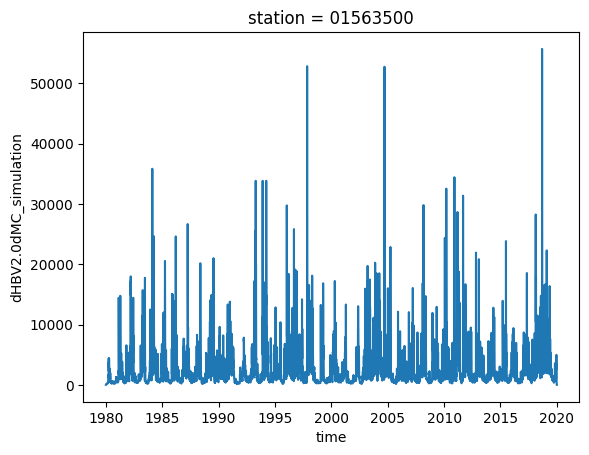

In [21]:
cloud_ds["dHBV2.0dMC_simulation"].sel(station="01563500").plot()